<a href="https://colab.research.google.com/github/cakennedy/greenguardians/blob/main/Forest_Project_EDAs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EDA for Deforestation from logging

This source code of this notebook was adopted from the Medium post - [Fast(er) Downloads](https://gorelick.medium.com/fast-er-downloads-a2abd512aa26) by Noel Gorelick. Credits to Noel.  

### Install packages

Uncomment the following line to install the required packages.

In [ ]:
!pip install -q geemap
!pip install -q retry
!pip install -q rasterio
!pip install -q shapely
!pip install -q geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 61.9 MB/s eta 0:00:00
  

### Import libraries & Initialize GEE

In [ ]:
import ee
#import geemap # Use this instead on your local laptop or AWS
import geemap.foliumap as geemap
import logging
import multiprocessing
import os
import requests
import shutil
from retry import retry
import pandas as pd
from google.colab import files
from pathlib import Path
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=4P7nutHAG85G12D7hRiDift0TyjuN3jxLYS90KNIiRw&tc=yJZukW-eHZXbYDF7ohkeBASQuYAXKkFh2ipIfrgUUyU&cc=2UpKlFru77GO8oDhTrJlkfkw_INhVuBdGLAeVB7tMIs

The authorization workflow will generate a code, which you should paste in the box below.


### Upload the sites CSV file

In [ ]:
file_path = Path("./sites.csv")
if not file_path.exists():
    sites = files.upload()

### Data Collection Prep
The data will be used for training and visualizing the places.

In [ ]:
sites = pd.read_csv('sites.csv').sample(frac=1)
print("Sites size = ", sites.shape[0])
sites[:5]

Sites size =  291


,Site Name,Selected Site,Latitude,Longitude,Year Logged,Age of clearcut at verification,Total area ( hectares ),Total logging scar footprint ( hectares ),Logging scars percent of total area,Notes
176,Normandy - Site 11,False,50.4463,-91.0825,NaN,NaN,NaN,NaN,NaN,NaN
113,Caribou Lake - Site 25,False,50.3324,-88.9387,NaN,NaN,NaN,NaN,NaN,NaN
283,Watin - Site 18,False,50.3300,-91.2652,NaN,NaN,NaN,NaN,NaN,NaN
6,Normandy-301,True,50.3972,-91.0266,1999.0,19.0,271.3,38.7,14.26%,NaN
243,HWY642 - Site 07,False,49.9477,-91.6722,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Parameters that will control on how the data will be collected
params = {
    'dimensions': '512x512',  # The dimension of each image chip
    'format': "GEO_TIFF",  # The output image format, can be png, jpg, ZIPPED_GEO_TIFF, GEO_TIFF, NPY
    'prefix': 'tile_',  # The filename prefix
    'processes': 2,  # How many processes to used for parallel processing
    'out_dir': '/content/tiles',  # The output directory. Default to the current working directly
}

# Removing clouds
def maskS2clouds(image):
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
      .And(qa.bitwiseAnd(cirrusBitMask).eq(0))

  return image.updateMask(mask).divide(10000)

# Defining the image from where the data will be collected
image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
                  .filterDate('2023-05-01', '2023-09-30') \
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
                  .map(maskS2clouds) \
                  .select('B8', 'B4', 'B3') \
                  .median() \
                  .visualize(min=0.0, max=0.3)
projection = image.projection().getInfo()
print(projection)

# Generate a list of locations from the pre-selected locations CSV file
def getRequests():
    sites = pd.read_csv('sites.csv')
    locations, points = [], []
    for index, row in sites.iterrows():
        locations.append([row["Longitude"], row["Latitude"]])
        points.append(ee.Feature(ee.Geometry.Point([row["Longitude"], row["Latitude"]]), {'category': 1}))
    
    return locations, ee.FeatureCollection(points)

# This section will get the data from GEE
@retry(tries=10, delay=1, backoff=2)
def getResult(index, location):
    point = ee.Geometry.Point(location)
    region = ee.Geometry.Polygon([[
        [location[0]+.025, location[1]-.025],
        [location[0]+.025, location[1]+.025],
        [location[0]-.025, location[1]+.025],
        [location[0]-.025, location[1]-.025],
        [location[0]+.025, location[1]-.025],
    ]], None, False,)

    if params['format'] in ['png', 'jpg']:
        url = image.getThumbURL(
            {
                'region': region,
                'dimensions': params['dimensions'],
                'format': params['format'],
            }
        )
    else:
        url = image.getDownloadURL(
            {
                'region': region,
                'dimensions': params['dimensions'],
                #'scale': 10,
                'format': params['format'],
                #'bands': ['B8', 'B4', 'B3'],
                #'crs': projection['crs'],
                #'crs_transform': projection['transform'],

            }
        )

    if params['format'] == "GEO_TIFF":
        ext = 'tif'
    else:
        ext = params['format']

    r = requests.get(url, stream=True)
    if r.status_code != 200:
        r.raise_for_status()

    out_dir = os.path.abspath(params['out_dir'])
    basename = str(index).zfill(len(str(params['count'])))
    filename = f"{out_dir}/{params['prefix']}{basename}.{ext}"
    with open(filename, 'wb') as out_file:
        shutil.copyfileobj(r.raw, out_file)
    print("Done: ", basename)

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}


### Download Images

In [ ]:
%%time
!mkdir -p {params['out_dir']}

logging.basicConfig()
locations, points = getRequests()
params['count'] = len(locations)

pool = multiprocessing.Pool(params['processes'])
pool.starmap(getResult, enumerate(locations[:2])) # TODO remove the :2

pool.close()

Done:  000
Done:  001
CPU times: user 177 ms, sys: 135 ms, total: 312 ms
Wall time: 10.1 s


### Deforestation from logging sample points

In [ ]:
rgb_image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
                  .filterDate('2023-05-01', '2023-09-30') \
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
                  .map(maskS2clouds).select('B4', 'B3', 'B2').median() \
                  .visualize(min=0.0, max=0.3)
false_color_image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
              .filterDate('2023-05-01', '2023-09-30') \
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
              .map(maskS2clouds).select('B8', 'B4', 'B3').median() \
              .visualize(min=0.0, max=0.3)
agri_color_image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
              .filterDate('2023-05-01', '2023-09-30') \
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
              .map(maskS2clouds).select('B11', 'B8', 'B2').median() \
              .visualize(min=0.0, max=0.3)
ndvi_image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
              .filterDate('2023-05-01', '2023-09-30') \
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
              .map(maskS2clouds).select('B8', 'B4').median()
nir = ndvi_image.select('B8')
red = ndvi_image.select('B4')
ndviImage = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
ndvi_image = ndviImage.visualize(min=-1, max=1, palette = ['blue', 'white', 'green'])

locations, points = getRequests()
print("Locations = ", len(locations))
center    = points.geometry().centroid().coordinates().getInfo()
colorised_w = points.style(**{'fillColor': '00000000', 'color': 'white'})
colorised_r = points.style(**{'fillColor': '00000000', 'color': 'red'})

Map = geemap.Map(show_map=False)
Map.setOptions('SATELLITE')
Map.setOptions('TERRAIN')
Map.addLayer(rgb_image, {}, "RGB", False)
Map.addLayer(false_color_image, {}, "False Color Infrared", False)
Map.addLayer(agri_color_image, {}, "Agriculture", False)
Map.addLayer(ndvi_image, {}, 'Vegetation Index - NDVI', False)
Map.addLayer(colorised_r, {}, "Sample points - Red")
Map.addLayer(colorised_w, {}, "Sample points - White", False)
Map.setCenter(center[0], center[1], 8)
Map

Locations =  291


### Sample Images in the Map

In [ ]:
Map = geemap.Map()
Map.setOptions('SATELLITE')

location = locations[0]
region = ee.Geometry.Polygon([[
    [location[0]+.025, location[1]-.025],
    [location[0]+.025, location[1]+.025],
    [location[0]-.025, location[1]+.025],
    [location[0]-.025, location[1]-.025],
    [location[0]+.025, location[1]-.025],
]], None, False,)

rgb_image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
                  .filterDate('2023-05-01', '2023-09-30') \
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
                  .map(maskS2clouds) \
                  .select('B4', 'B3', 'B2') \
                  .median() \
                  .visualize(min=0.0, max=0.2)

false_color_image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
             .filterBounds(region) \
              .filterDate('2023-05-01', '2023-09-30') \
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
              .map(maskS2clouds) \
              .select('B8', 'B4', 'B3') \
              .median() \
              .visualize(min=0.0, max=0.3) \
             .clip(region)

false_color_image_all = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
              .filterDate('2023-05-01', '2023-09-30') \
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
              .map(maskS2clouds) \
              .select('B8', 'B4', 'B3') \
              .median() \
              .visualize(min=0.0, max=0.3)

agri_color_image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
             .filterBounds(region) \
              .filterDate('2023-05-01', '2023-09-30') \
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
              .map(maskS2clouds) \
              .select('B11', 'B8', 'B2') \
              .median() \
              .visualize(min=0.0, max=0.3) \
             .clip(region)

ndvi_image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
             .filterBounds(region) \
              .filterDate('2023-05-01', '2023-09-30') \
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
              .map(maskS2clouds) \
              .select('B8', 'B4') \
              .median()

nir = ndvi_image.select('B8')
red = ndvi_image.select('B4')
ndviImage = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

ndvi_image = ndviImage.visualize(min=-1, max=1, palette = ['blue', 'white', 'green']) \
             .clip(region)

Map.addLayer(rgb_image, {}, "RGB", False)
Map.addLayer(false_color_image, {}, "False Color Infrared - Clip")
Map.addLayer(false_color_image_all, {}, "False Color Infrared - All", False)
Map.addLayer(agri_color_image, {}, "Agriculture", False)
Map.addLayer(ndvi_image, {}, 'Vegetation Index - NDVI', False)
Map.add_geojson('/content/map.geojson', layer_name="Logging lines", style = {'color': 'white', 'weight': 0.5})

#Map.addLayer(region, {}, "ROI", False)
Map.setCenter(location[0], location[1], 12)
Map

### Sample Images Solo

3
512 512


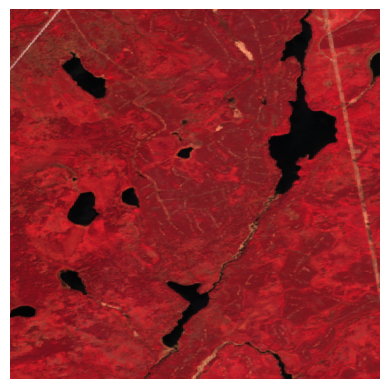

3
512 512


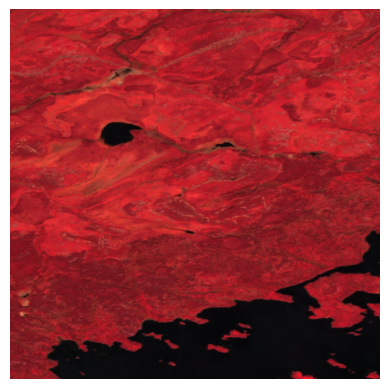

In [ ]:
drive = "/content/tiles/"

import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

def loadTiff(in_image):
    src = gdal.Open(in_image)
    nbands = src.RasterCount
    print(nbands)
    in_band = src.GetRasterBand(1)
    print(in_band.XSize, in_band.YSize)
    xinit, yinit = (0, 0)
    block_xsize, block_ysize = (in_band.XSize, in_band.YSize)

    # read the (multiband) file into an array
    image = src.ReadAsArray(xinit, yinit, block_xsize, block_ysize)
    # reshape from bandsxheightxwidth to wxhxb
    image = np.moveaxis(image, 0, -1)
    return image, block_ysize, block_xsize, nbands

def RGBplot(image, index):
  img = np.dstack((image[:,:,index[0]], image[:,:,index[1]], image[:,:,index[2]]))
  f = plt.figure()
  plt.imshow(np.array(img))
  plt.axis('off')
  plt.show()

for image in sorted(os.listdir(drive)):
  if image.endswith('.tif'):
    [img, xsize, ysize, nbands] = loadTiff(os.path.join(drive, image))
    RGBplot(img, [0,1,2])

# GeoJSON to COCO format segmentation

In [ ]:
gdf = gpd.read_file('/content/map.geojson')

polygons = [row.geometry for idx, row in gdf.iterrows()]

# Load your GeoTIFF file
with rasterio.open('/content/tiles/tile_000.tif') as src:
    # Create an empty mask
    mask = geometry_mask(
        geometries=polygons, 
        out_shape=src.shape, 
        transform=src.transform, 
        invert=True
    )
    print(src.shape, src.transform)

# Convert the mask from boolean to integer type
mask = mask.astype(np.uint8)

# Find contours around the regions of the mask that are 1
contours = find_contours(mask, 0.5)

# COCO-formatted annotation will be a list of lists, each sublist will be for one object (or one contour in this case)
annotations = []

for contour in contours:
    # We need to flip the columns and rows because skimage returns them in (row, column) format
    contour = np.flip(contour, axis=1)
    # COCO format uses the (x, y) format
    segmentation = contour.ravel().tolist()
    annotations.append(segmentation)

(512, 512) | 0.00, 0.00,-91.55|
| 0.00,-0.00, 50.64|
| 0.00, 0.00, 1.00|


# Plotting GeoJSON Mask

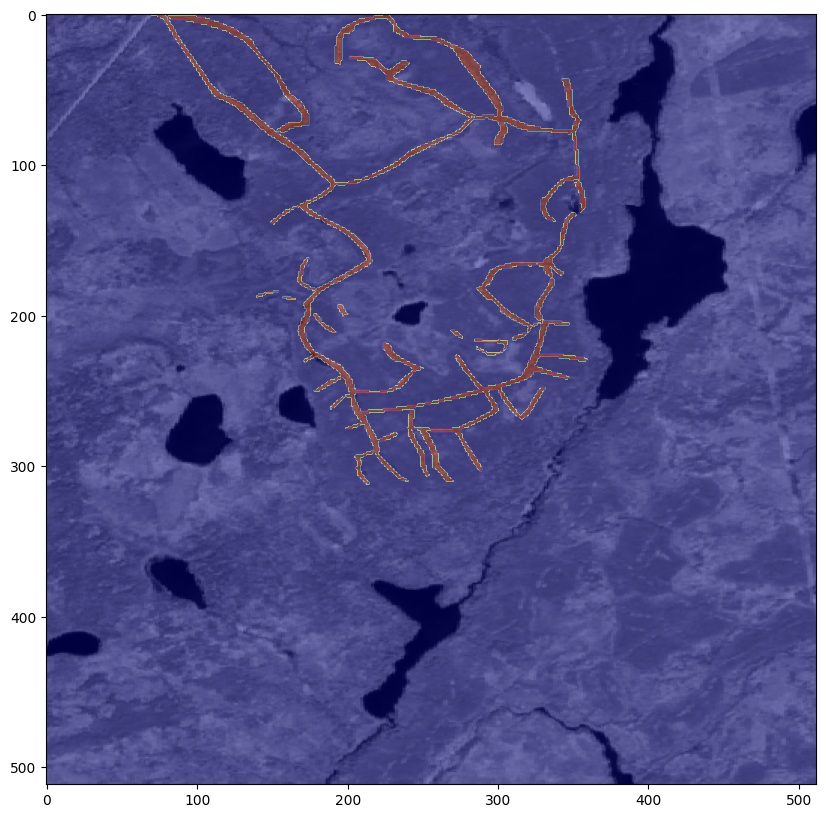

In [ ]:
# Load the GeoTIFF
with rasterio.open('/content/tiles/tile_000.tif') as src:
    img = src.read(1)

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')

# Overlay the mask
plt.imshow(mask, cmap='jet', alpha=0.5)

plt.show()

# Plotting COCO Mask

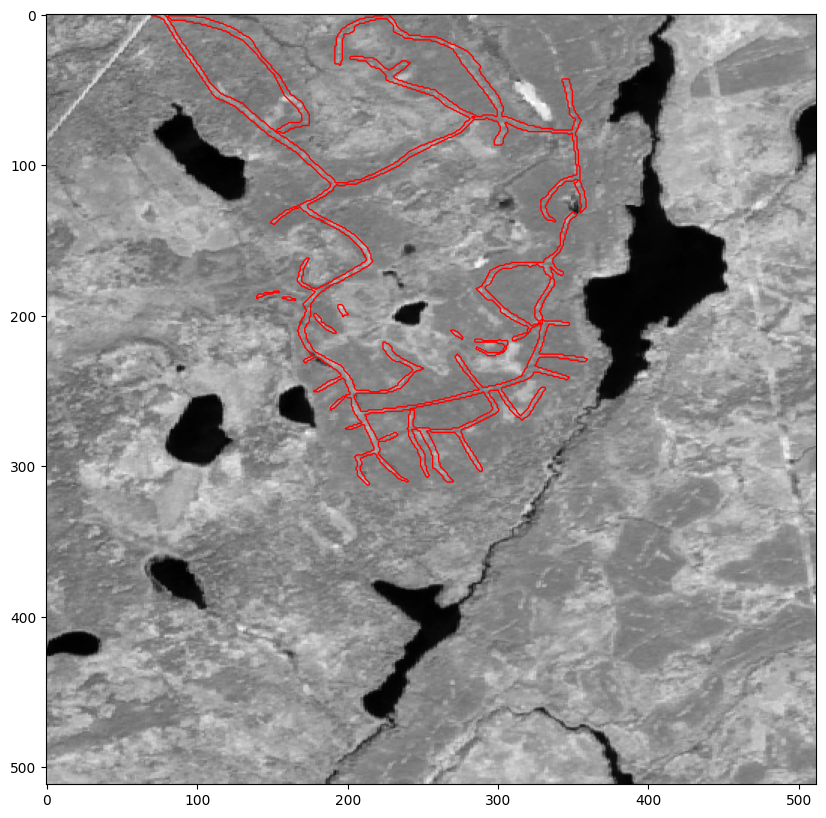

In [ ]:
44# Load the GeoTIFF
with rasterio.open('/content/tiles/tile_000.tif') as src:
    img = src.read(1)

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')

# Plot each annotation.
for annotation in annotations:
    # Convert the list of coordinates to an array and reshape it to be a 2-column array
    annotation = np.array(annotation).reshape(-1, 2)
    plt.plot(annotation[:, 0], annotation[:, 1], linewidth=1, color='red')

plt.show()

# Mask to GeoJSON Point convertion

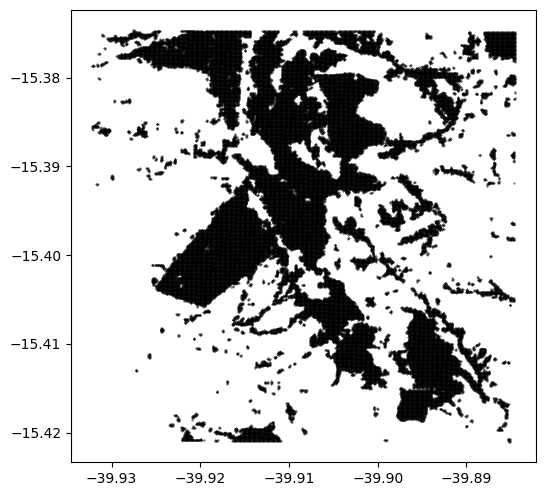

In [ ]:
import numpy as np
from osgeo import gdal, osr

# Open the GeoTIFF file
ds = gdal.Open('/content/S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_01_01_i.tif')
ds_m = gdal.Open('/content/S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_01_01_m.tif')

# Get the existing coordinate reference system
original_crs = osr.SpatialReference()
original_crs.ImportFromWkt(ds.GetProjection())

# Define the target coordinate reference system (WGS84)
target_crs = osr.SpatialReference()
target_crs.ImportFromEPSG(4326)

# Create a coordinate transformation object
transform = osr.CoordinateTransformation(original_crs, target_crs)

mask = ds_m.GetRasterBand(1).ReadAsArray()

# Identify the pixels of interest (replace 255 with the relevant value)
pixels_of_interest = np.where(mask == 1)

# Initialize an empty list to store geographic coordinates
geo_coords = []

# Loop through each pixel of interest
for pixel_index in range(pixels_of_interest[0].shape[0]):
    # Get the pixel coordinates
    coord = (pixels_of_interest[0][pixel_index], pixels_of_interest[1][pixel_index])
    # Convert pixel coordinate to georeferenced coordinate
    x_geo, y_geo = ds.GetGeoTransform()[0] + coord[1] * ds.GetGeoTransform()[1], ds.GetGeoTransform()[3] + coord[0] * ds.GetGeoTransform()[5]
    # Transform the coordinate
    lon, lat, _ = transform.TransformPoint(x_geo, y_geo)
    geo_coords.append((lat, lon))

import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Convert geographic coordinates to Points
geo_points = [Point(coord) for coord in geo_coords]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=geo_points)

# Plot the points
fig, ax = plt.subplots(figsize=(6, 6))
gdf.plot(ax=ax, color='black', markersize=0.1)

plt.show()

In [ ]:
with rasterio.open('/content/S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_01_01_m.tif') as x:
    src = x

In [ ]:
import rasterio

# Assume binary_mask is your binary mask
binary_mask = mask

# Convert the segmentation mask to a GeoTIFF
with rasterio.open('mask.tif', 'w', driver='GTiff', height=mask.shape[0],
                   width=mask.shape[1], count=1, dtype=mask.dtype,
                   crs=src.crs, transform=src.transform) as dst:
    dst.write(mask, 1)

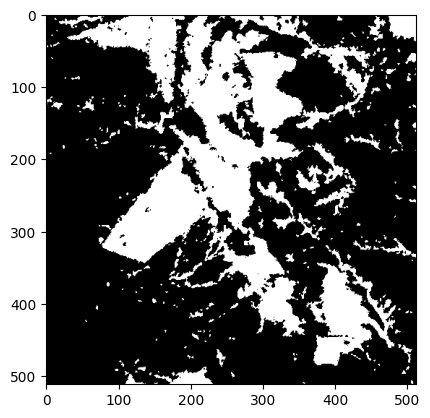

In [ ]:
#@title
import cv2 as cv

image = cv.imread('/content/mask.tif', cv.IMREAD_UNCHANGED)

fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
plt.show()

# GEE Demo

In [ ]:
Map = geemap.Map()
Map.setOptions('SATELLITE')

rgb_image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
                  .filterDate('2023-05-01', '2023-09-30') \
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
                  .map(maskS2clouds) \
                  .select('B4', 'B3', 'B2') \
                  .median() \
                  .visualize(min=0.0, max=0.2)

mask_image = ee.Image('projects/w210-capstone-2/assets/mask')
mask_image2 = mask_image.updateMask(mask_image)
# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 1,
  'palette': ['00000000', 'red']  # Assuming mask values range from 0 to 1
}

# Add the image layer to the map and display it.
Map.addLayer(mask_image2, vis_params, 'Mask')
Map.addLayer(rgb_image, {}, "RGB", False)
Map.setCenter(-39.912862506353875, -15.37499744831757, 12)
Map

Map(center=[-15.37499744831757, -39.912862506353875], controls=(ZoomControl(options=['position', 'zoom_in_text…

# Atlantic Forest

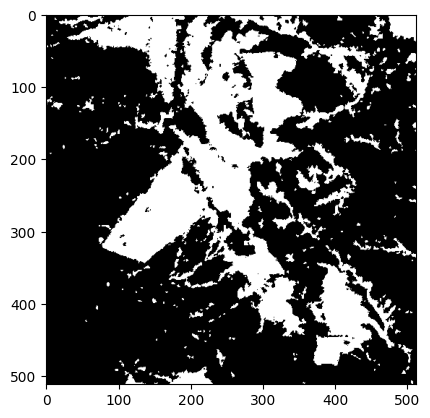

In [ ]:
#@title
import cv2 as cv

image = cv.imread('/content/S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_01_01_m.tif', cv.IMREAD_UNCHANGED)

fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
plt.show()

(512, 512, 3)


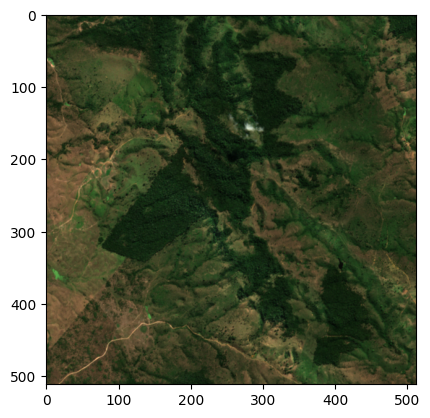

In [ ]:
#@title
from rasterio.plot import show

dataset = rasterio.open("/content/S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_01_01.tif")
#dataset = rasterio.open("/content/tiles/tile_000.tif")

b1 = dataset.read(1)
b2 = dataset.read(2)
b3 = dataset.read(3)
#b4 = dataset.read(4)

rgb_image = np.dstack((b1, b2, b3))
#rgb_image = np.dstack((b4, b1, b2))

rgb_image = rgb_image.astype(np.float32)
rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))
print(rgb_image.shape)

plt.imshow(rgb_image)
plt.show()

dataset.close()

# For Amazone

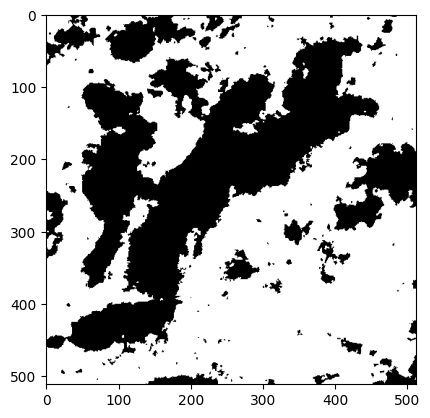

In [ ]:
#@title
import cv2 as cv

image = cv.imread('/content/amz/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_04_m.tif', cv.IMREAD_UNCHANGED)

fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
plt.show()

(512, 512, 3)


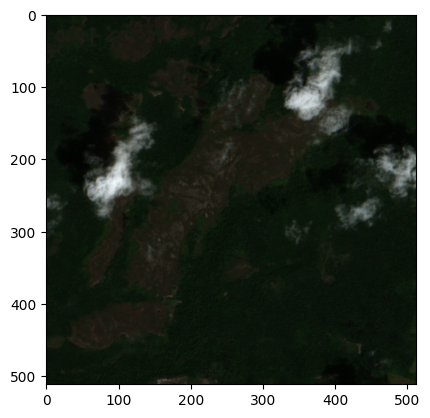

In [ ]:
#@title
from rasterio.plot import show

dataset = rasterio.open("/content/amz/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_04_i.tif")
#dataset = rasterio.open("/content/tiles/tile_000.tif")

b1 = dataset.read(1)
b2 = dataset.read(2)
b3 = dataset.read(3)
#b4 = dataset.read(4)

rgb_image = np.dstack((b1, b2, b3))
#rgb_image = np.dstack((b4, b1, b2))

rgb_image = rgb_image.astype(np.float32)
rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))
print(rgb_image.shape)

plt.imshow(rgb_image)
plt.show()

dataset.close()

# Download and crop